# EHR A3
## GROUP: B
## MEMBERS: ERNEST CEBALLOS, JÚLIA GALIMANY, ORIOL GALIMANY


In [1]:
library(dplyr)
library(tidyr)
library(tibble)
library(lubridate)
library(readr)
library(stringr)
library(ggplot2)
library(data.table)
library(odbc)
library(RMariaDB)
library(DBI)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
con <- dbConnect(
  drv = RMariaDB::MariaDB(),
  username = "ernest.ceballos",
  password = "EeWot5Bu",
  host = "ehr3.deim.urv.cat",
  dbname = "mimiciiiv14",
  port = 3306
)

# PART 1: COHORT 

### Cohort definition
We performed a retrospective observational study using the Medical Information Mart for Intensive Care III (MIMIC-III), version 1.4, a publicly available database containing de-identified health data from over 40,000 adult and neonatal ICU admissions at Beth Israel Deaconess Medical Center between 2001 and 2012 [1]. Our cohort comprised all adult patients aged 16 years or older with at least one ICU admission recorded in the ICUSTAYS table. Age was calculated as the difference in years between the ICU admission time (INTIME) and the patient’s date of birth. For patients with multiple ICU stays, each stay was considered an independent observation. Neonatal and pediatric admissions (age < 16 years) were excluded. The final analytical cohort included all qualifying ICU admissions available in the database, without further exclusion criteria.


In [3]:
cohort <- tbl(con, "ICUSTAYS") %>%
  inner_join(tbl(con, "ADMISSIONS"), by = c("HADM_ID" = "HADM_ID", "SUBJECT_ID" = "SUBJECT_ID")) %>%
  inner_join(tbl(con, "PATIENTS"), by = c("SUBJECT_ID" = "SUBJECT_ID")) %>%
  mutate(
    age = year(INTIME) - year(DOB)
  ) %>%
  filter(age >= 16) %>%
  select(
    HADM_ID,
    SUBJECT_ID,
    ICUSTAY_ID,
    age,
    GENDER,
    INTIME,
    OUTTIME,
    HOSPITAL_EXPIRE_FLAG
  ) %>%
  distinct() %>%
  collect()

colnames(cohort) <- tolower(colnames(cohort))

cat("Cohort created successfully.\n")
cat("Total ICU admissions:", nrow(cohort), "\n")
cat("Unique patients:", n_distinct(cohort$subject_id), "\n")
cat("Age range:", min(cohort$age, na.rm = TRUE), "-", max(cohort$age, na.rm = TRUE), "years\n")
cat("Female proportion:", round(mean(cohort$gender == "F") * 100, 1), "%\n")


dir.create("data", showWarnings = FALSE)
write.csv(cohort, "data/cohort.csv", row.names = FALSE)


Cohort created successfully.
Total ICU admissions: 53424 
Unique patients: 38598 
Age range: 16 - 311 years
Female proportion: 43.7 %


# PART 2: Sepsis prevalence

In [4]:
# Define sepsis using ICD-9-CM codes
sepsis_adm <- tbl(con, "DIAGNOSES_ICD") %>%
  filter(
    substr(ICD9_CODE, 1, 3) == "038" |
    ICD9_CODE %in% c("99591", "99592", "78552")
  ) %>%
  select(HADM_ID) %>%
  distinct() %>%
  collect()
# Standardize column names to lowercase for consistency
colnames(sepsis_adm) <- tolower(colnames(sepsis_adm))


In [5]:
cohort_sepsis <- cohort %>%
  mutate(
    sepsis = if_else(hadm_id %in% sepsis_adm$hadm_id, 1, 0)  # 1 = with sepsis, 0 = without sepsis
  )

In [6]:
# Calculate the total volume and proportion (prevalence) of sepsis cases within the ICU
sepsis_summary <- cohort_sepsis %>%
  summarise(
    total_icu_admissions = n(),
    sepsis_icu_admissions = sum(sepsis),
    sepsis_prevalence = sepsis_icu_admissions / total_icu_admissions
  )

sepsis_summary


total_icu_admissions,sepsis_icu_admissions,sepsis_prevalence
<int>,<dbl>,<dbl>
53424,7261,0.1359127


In [7]:
table(cohort_sepsis$sepsis)


    0     1 
46163  7261 

## PART 3: Sepsis Mortality 

First of all I will extract the HADM_ID with sepsis using the following ICD9_CODES ('99591','99592','78552') from the DIAGNOSES_ICD table, independently on which seq_num they are. Then for the others HADM_ID (that don't have the sepsis code) I will pick the ICD9_CODE present in seq_num = 1. I will create a column with sepsis present = 1, and sepsis no present = 0. At last I will do an inner join with the ICUSTAY table to obtain only the HADM_ID that were ingressed at the UCI, and last I will use the HOSPITAL_EXPIRE_FLAG from admissions to create a status (alive, deceased) column. 

In [8]:
sql <- "
WITH 
SEP_ADM AS (
SELECT HADM_ID, ICD9_CODE
FROM DIAGNOSES_ICD
WHERE ICD9_CODE IN ('99591','99592','78552') OR ICD9_CODE LIKE '038%'
GROUP BY HADM_ID
),
NOSEP_ADM AS (
SELECT HADM_ID, ICD9_CODE
FROM DIAGNOSES_ICD
WHERE 
	SEQ_NUM = 1
	AND HADM_ID NOT IN (
		SELECT DISTINCT HADM_ID
    	FROM DIAGNOSES_ICD
    	WHERE ICD9_CODE IN ('99591', '99592', '78552') OR ICD9_CODE LIKE '038%')
),
UN_SEP AS (
SELECT *
FROM SEP_ADM 
UNION ALL
SELECT *
FROM NOSEP_ADM
),
SEPS AS (
SELECT 
	u.HADM_ID,
	a.SUBJECT_ID,
	u.ICD9_CODE,
	dd.SHORT_TITLE,
	CASE 
		WHEN u.ICD9_CODE IN ('99591', '99592', '78552') THEN 1
		WHEN u.ICD9_CODE LIKE '038%' THEN 1
		ELSE 0
	END AS SEPSIS,
	a.HOSPITAL_EXPIRE_FLAG 
FROM UN_SEP u
INNER JOIN D_ICD_DIAGNOSES dd ON u.ICD9_CODE = dd.ICD9_CODE
INNER JOIN ADMISSIONS a ON u.HADM_ID = a.HADM_ID
),
ICU_JOIN AS (
SELECT 
	s.HADM_ID, s.SUBJECT_ID, 
	MIN(i.ICUSTAY_ID) AS ICUSTAY_ID, #To only keep one of the ICUSTAYS if there are multiple per HADM_ID 
	s.ICD9_CODE, s.SHORT_TITLE, s.SEPSIS, 
	CASE 
		WHEN s.HOSPITAL_EXPIRE_FLAG = 1 THEN 'Deceased'
		ELSE 'Alive'
	END AS STATUS
FROM SEPS s
INNER JOIN ICUSTAYS i ON s.HADM_ID = i.HADM_ID
GROUP BY s.HADM_ID 
)
SELECT *
FROM ICU_JOIN
"
mortality_df <- dbGetQuery(con, sql) 

In [9]:
head(mortality_df)

,HADM_ID,SUBJECT_ID,ICUSTAY_ID,ICD9_CODE,SHORT_TITLE,SEPSIS,STATUS
,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>
1,100001,58526,275225,25013,DMI ketoacd uncontrold,0,Alive
2,100003,54610,209281,53100,Ac stomach ulcer w hem,0,Alive
3,100006,9895,291788,49320,Chronic obst asthma NOS,0,Alive
4,100007,23018,217937,56081,Intestinal adhes w obstr,0,Alive
5,100009,533,253656,41401,Crnry athrscl natve vssl,0,Alive
6,100010,55853,271147,1890,Malig neopl kidney,0,Alive


In [10]:
#Mortality tables for Sepsis and No sepsis
#I will use the deaths in percentage from the total of the group

STATUS,count,Percentage_Status
<chr>,<int>,<dbl>
Alive,4375,68.87594
Deceased,1977,31.12406


Mortality rate of sepsis is 31.12406 %

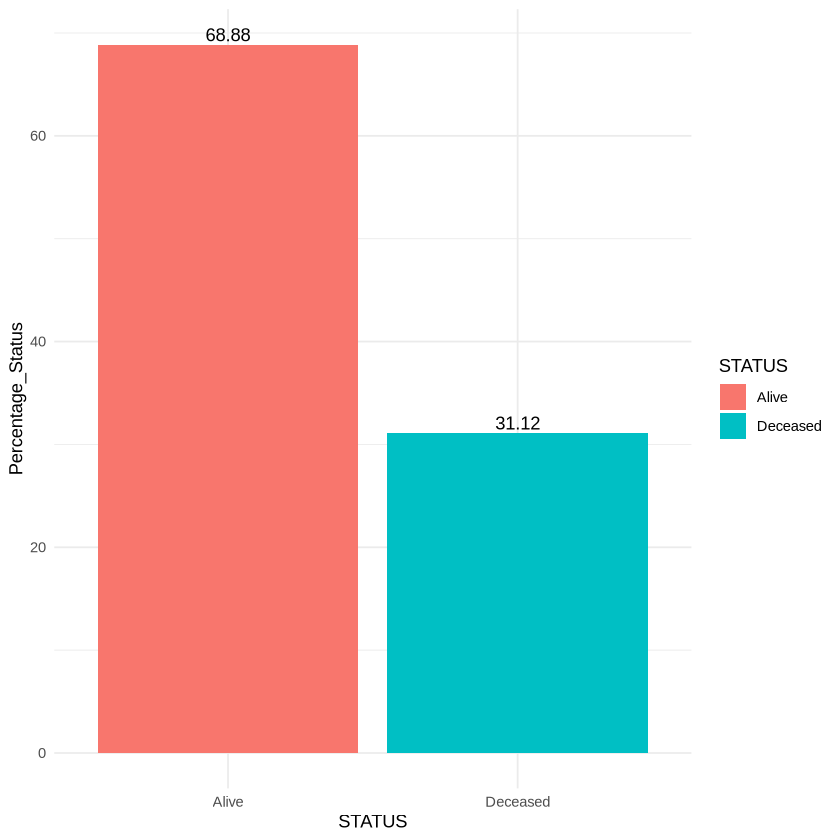

In [11]:
#With sepsis:
df2 <- mortality_df %>%
  filter(SEPSIS == 1) %>%
  group_by(STATUS)%>%
  summarise(count = n())%>%
  mutate(Percentage_Status = count / sum(count) * 100)

head(df2)

mortality_sepsis <- df2 %>%
  filter(STATUS == 'Deceased') %>%
  pull(Percentage_Status)
cat("Mortality rate of sepsis is", mortality_sepsis, "%")

ggplot(df2,
       aes(x=STATUS, 
           y=Percentage_Status, 
           fill = STATUS, 
           label=round(Percentage_Status,2))
       ) +
  geom_col() +
  geom_text(position=position_dodge(0.5), vjust=-0.25) +
  theme_minimal()

STATUS,count,Percentage_Status
<chr>,<int>,<dbl>
Alive,46997,92.546572
Deceased,3785,7.453428


Mortality rate without sepsis is 7.453428 %

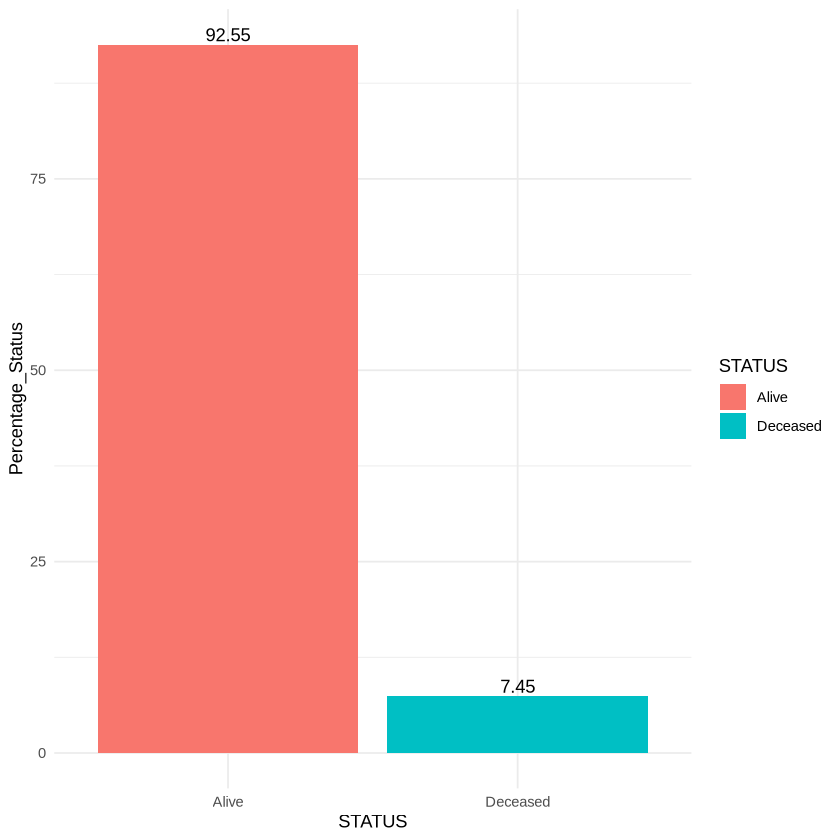

In [12]:
#Without Sepsis
df2 <- mortality_df %>%
  filter(SEPSIS == 0) %>%
  group_by(STATUS)%>%
  summarise(count = n())%>%
  mutate(Percentage_Status = count / sum(count) * 100)

head(df2)

mortality_sepsis <- df2 %>%
  filter(STATUS == 'Deceased') %>%
  pull(Percentage_Status)
cat("Mortality rate without sepsis is", mortality_sepsis, "%")

ggplot(df2,
       aes(x=STATUS, 
           y=Percentage_Status, 
           fill = STATUS, 
           label=round(Percentage_Status,2))
       ) +
  geom_col() +
  geom_text(position=position_dodge(0.5), vjust=-0.25) +
  theme_minimal()

In [13]:
#Fins aqui lko que he fet pel meu compte
#Repetiré els gràfics amb la cohort de la part 2. 

In [14]:
#Enrecordeu-vos de tractar les columnes de factor com a tal
head(cohort_sepsis)

fact_cols <- c('hadm_id', 'subject_id', 'icustay_id', 'hospital_expire_flag', 'sepsis')
cohort_sepsis[fact_cols] = lapply(cohort_sepsis[fact_cols],as.factor)
head(cohort_sepsis)

hadm_id,subject_id,icustay_id,age,gender,intime,outtime,hospital_expire_flag,sepsis
<int>,<int>,<int>,<int>,<chr>,<dttm>,<dttm>,<int>,<dbl>
145834,3,211552,76,M,2101-10-20 19:10:11,2101-10-26 20:43:09,0,1
185777,4,294638,48,F,2191-03-16 00:29:31,2191-03-17 16:46:31,0,0
107064,6,228232,66,F,2175-05-30 21:30:54,2175-06-03 13:39:54,0,0
150750,9,220597,41,M,2149-11-09 13:07:02,2149-11-14 20:52:14,1,0
194540,11,229441,50,F,2178-04-16 06:19:32,2178-04-17 20:21:05,0,0
112213,12,232669,72,M,2104-08-08 02:08:17,2104-08-15 17:22:25,1,0


hadm_id,subject_id,icustay_id,age,gender,intime,outtime,hospital_expire_flag,sepsis
<fct>,<fct>,<fct>,<int>,<chr>,<dttm>,<dttm>,<fct>,<fct>
145834,3,211552,76,M,2101-10-20 19:10:11,2101-10-26 20:43:09,0,1
185777,4,294638,48,F,2191-03-16 00:29:31,2191-03-17 16:46:31,0,0
107064,6,228232,66,F,2175-05-30 21:30:54,2175-06-03 13:39:54,0,0
150750,9,220597,41,M,2149-11-09 13:07:02,2149-11-14 20:52:14,1,0
194540,11,229441,50,F,2178-04-16 06:19:32,2178-04-17 20:21:05,0,0
112213,12,232669,72,M,2104-08-08 02:08:17,2104-08-15 17:22:25,1,0


hospital_expire_flag,count,Percentage_Status
<fct>,<int>,<dbl>
0,4896,67.42873
1,2365,32.57127


Sepsis mortality rate is 32.57127 %

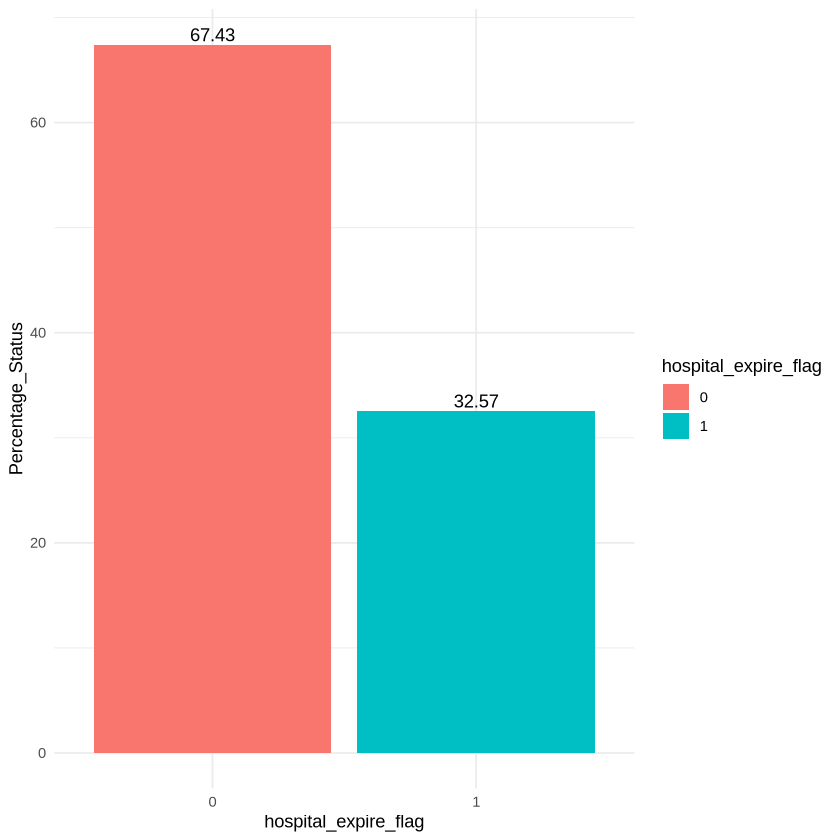

In [15]:
#With sepsis
df2 <- cohort_sepsis%>%
    filter(sepsis == 1) %>%
    select(hospital_expire_flag) %>%
    group_by(hospital_expire_flag)%>%
    summarise(count = n())%>%
    mutate(Percentage_Status = count / sum(count) * 100)
head(df2)

mortality_sepsis <- df2 %>%
  filter(hospital_expire_flag == 1) %>%
  pull(Percentage_Status)
cat("Sepsis mortality rate is", mortality_sepsis, "%")

ggplot(df2,
       aes(x=hospital_expire_flag, 
           y=Percentage_Status, 
           fill = hospital_expire_flag, 
           label=round(Percentage_Status,2))
       ) +
  geom_col() +
  geom_text(position=position_dodge(0.5), vjust=-0.25) +
  theme_minimal()

hospital_expire_flag,count,Percentage_Status
<fct>,<int>,<dbl>
0,41984,90.947295
1,4179,9.052705


Mortality rate without sepsis is 9.052705 %

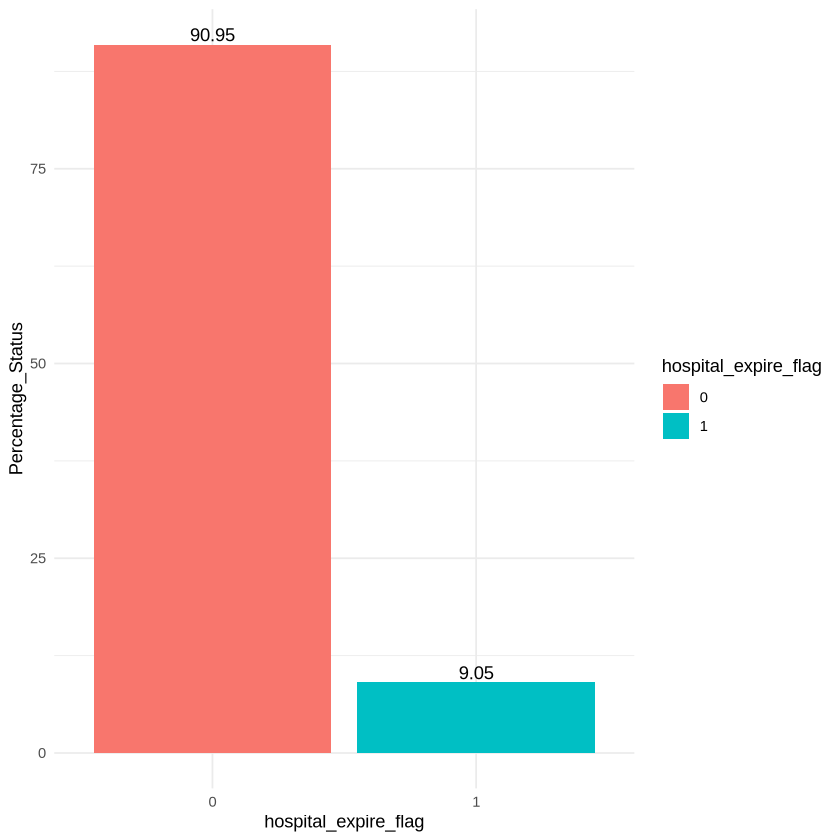

In [16]:
#Without sepsis 
df2 <- cohort_sepsis%>%
    filter(sepsis == 0) %>%
    select(hospital_expire_flag) %>%
    group_by(hospital_expire_flag)%>%
    summarise(count = n())%>%
    mutate(Percentage_Status = count / sum(count) * 100)
head(df2)

mortality_sepsis <- df2 %>%
  filter(hospital_expire_flag == 1) %>%
  pull(Percentage_Status)
cat("Mortality rate without sepsis is", mortality_sepsis, "%")

ggplot(df2,
       aes(x=hospital_expire_flag, 
           y=Percentage_Status, 
           fill = hospital_expire_flag, 
           label=round(Percentage_Status,2))
       ) +
  geom_col() +
  geom_text(position=position_dodge(0.5), vjust=-0.25) +
  theme_minimal()

## PART 4: DATA PREPARATION FOR LOGISTIC REGRESSION PREDICTION MODEL

In [17]:
# Construcció de la nova taula amb els predictors 
cohort_model <- tbl(con, "ICUSTAYS") %>%
  inner_join(tbl(con, "ADMISSIONS"), by = c("HADM_ID" = "HADM_ID", "SUBJECT_ID" = "SUBJECT_ID")) %>%
  inner_join(tbl(con, "PATIENTS"), by = c("SUBJECT_ID" = "SUBJECT_ID")) %>%
  inner_join(tbl(con, "DIAGNOSES_ICD"), by = c("HADM_ID" = "HADM_ID", "SUBJECT_ID" = "SUBJECT_ID")) %>%
  mutate(
    age = year(INTIME) - year(DOB)
  ) %>%
  filter(age >= 16) %>%
  select(
    HADM_ID,
    SUBJECT_ID,
    ICUSTAY_ID,
    age,
    GENDER,
    ETHNICITY,
    INSURANCE,
    ICD9_CODE,
    HOSPITAL_EXPIRE_FLAG
  ) %>%
  collect()

colnames(cohort_model) <- tolower(colnames(cohort_model))

head(cohort_model)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag
<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
145834,3,211552,76,M,WHITE,Medicare,0389,0
145834,3,211552,76,M,WHITE,Medicare,78559,0
145834,3,211552,76,M,WHITE,Medicare,5849,0
145834,3,211552,76,M,WHITE,Medicare,4275,0
145834,3,211552,76,M,WHITE,Medicare,41071,0
145834,3,211552,76,M,WHITE,Medicare,4280,0


## PART 5: LOGISTIC REGRESSION MODEL
We will perform a logistic regression on sepsis patients to see if we can predict if they die using the predictors age, gender, ethnicity, insurance, and icd9-code. 

La cohort final ha de tenir si tene sepsis o no (ja que veig que hi ha icd9_codes repetits ja que un amteix hadm_id en pot tenir varis). Lo que faig es afegir una columna sepsis, en que si el codi coincideix amb sepsis posa un 1, i sinó posa un 0. 

In [18]:
cohort_final <- cohort_model %>%
  mutate(sepsis = if_else(
    str_starts(icd9_code, "038") | 
      icd9_code %in% c("99591", "99592", "78552"), 
    1, 0))

In [19]:
head(cohort_final,5)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag,sepsis
<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
145834,3,211552,76,M,WHITE,Medicare,0389,0,1
145834,3,211552,76,M,WHITE,Medicare,78559,0,0
145834,3,211552,76,M,WHITE,Medicare,5849,0,0
145834,3,211552,76,M,WHITE,Medicare,4275,0,0
145834,3,211552,76,M,WHITE,Medicare,41071,0,0


In [20]:
dim(cohort_final)

[1] 658810     10

Ara lo que faré serà agrupar per SUBJECT_ID, HADM_ID, i ICUSTAY_ID, per tant tindrem que cada ICUSTAY_ID pot tenir varis codis de sepsis, llavors fico primer els que siguin sepsis = 1 (tenen sepsis). Agropo per subject_id, hadm_id, icustay_id i lavorns agafo de cada grup només la primera filera que surti (com que els que tenen sepsis estan a dalt em sortian els primers, per lo que com en al cohort de la julia prioritzo agafar el ICD9_CODE de sepsis i no els altres). 



In [21]:
cohort_unique <- cohort_final %>%
  group_by(subject_id, hadm_id, icustay_id) %>%
  arrange(desc(sepsis)) %>% #Sepsis registers appears first
  slice(1) %>% #takes only the very first row of each group
  ungroup()

In [22]:
dim(cohort_unique)
dim(cohort_sepsis) #comparant amb la de la júlia

[1] 53424    10

[1] 53424     9

In [23]:
#Preparo el dataframe indicant les columnes que son factor
fact_cols <- c('hadm_id', 'subject_id', 'icustay_id', 'hospital_expire_flag', 'sepsis', 'ethnicity', 'insurance', 'icd9_code')
cohort_unique[fact_cols] = lapply(cohort_unique[fact_cols],as.factor)
head(cohort_unique)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag,sepsis
<fct>,<fct>,<fct>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>
145834,3,211552,76,M,WHITE,Medicare,0389,0,1
185777,4,294638,48,F,WHITE,Private,042,0,0
107064,6,228232,66,F,WHITE,Medicare,40391,0,0
150750,9,220597,41,M,UNKNOWN/NOT SPECIFIED,Medicaid,431,1,0
194540,11,229441,50,F,WHITE,Private,1913,0,0
112213,12,232669,72,M,WHITE,Medicare,1570,1,0


In [24]:
patients_sepsis <- cohort_unique %>%
    filter(sepsis ==1)

head(patients_sepsis)

hadm_id,subject_id,icustay_id,age,gender,ethnicity,insurance,icd9_code,hospital_expire_flag,sepsis
<fct>,<fct>,<fct>,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>
145834,3,211552,76,M,WHITE,Medicare,0389,0,1
111970,21,216859,88,M,WHITE,Medicare,0388,1,1
176176,33,296681,82,M,UNKNOWN/NOT SPECIFIED,Medicare,0389,0,1
185910,38,248910,76,M,WHITE,Medicare,0389,0,1
189535,61,217135,56,M,WHITE,Private,0389,1,1
116009,62,216609,69,M,PATIENT DECLINED TO ANSWER,Medicare,03849,0,1


In [25]:
#Checking for NA values
anyNA(cohort_unique)
sum(is.na(cohort_unique))
summary(cohort_unique)

[1] TRUE

[1] 14

    hadm_id        subject_id      icustay_id         age        
 163281 :    7   13033  :   41   200001 :    1   Min.   : 16.00  
 186706 :    7   109    :   38   200003 :    1   1st Qu.: 53.00  
 109520 :    6   11861  :   35   200006 :    1   Median : 66.00  
 123178 :    6   5060   :   31   200007 :    1   Mean   : 74.73  
 175448 :    6   19213  :   25   200009 :    1   3rd Qu.: 78.00  
 108976 :    5   20643  :   25   200010 :    1   Max.   :311.00  
 (Other):53387   (Other):53229   (Other):53418                   
    gender                           ethnicity          insurance    
 Length:53424       WHITE                 :37908   Government: 1443  
 Class :character   BLACK/AFRICAN AMERICAN: 4751   Medicaid  : 4734  
 Mode  :character   UNKNOWN/NOT SPECIFIED : 4303   Medicare  :29811  
                    HISPANIC OR LATINO    : 1378   Private   :16854  
                    OTHER                 : 1178   Self Pay  :  582  
                    UNABLE TO OBTAIN      :  846    

In [26]:
#There are only 7 NA values in icd9_code (which is why there are 7 NA values in sepsis). For 7 rows, we will eliminate them. 
cohort_unique <- cohort_unique %>% drop_na()

### Sepsis prevalence

In [147]:
sepsis_prevalence <- cohort_unique %>%
  summarise(
    total_icu_admissions = n(),
    sepsis_icu_admissions = sum(sepsis == "1", na.rm = TRUE),
    sepsis_prevalence = (sepsis_icu_admissions / total_icu_admissions) * 100
  )

sepsis_prevalence

total_icu_admissions,sepsis_icu_admissions,sepsis_prevalence
<int>,<int>,<dbl>
53417,7261,13.59305


In [116]:
#install.packages("DT")

In [158]:
library(DT)

datatable(sepsis_prevalence, 
          caption = 'Sepsis prevalence in the ICU',
          colnames = c('Total admissions', 'Sepsis cases', 'Prevalence'),
          options = list(dom = 't')) %>%
  formatRound('sepsis_prevalence', digits = 2)

HTML widgets cannot be represented in plain text (need html)

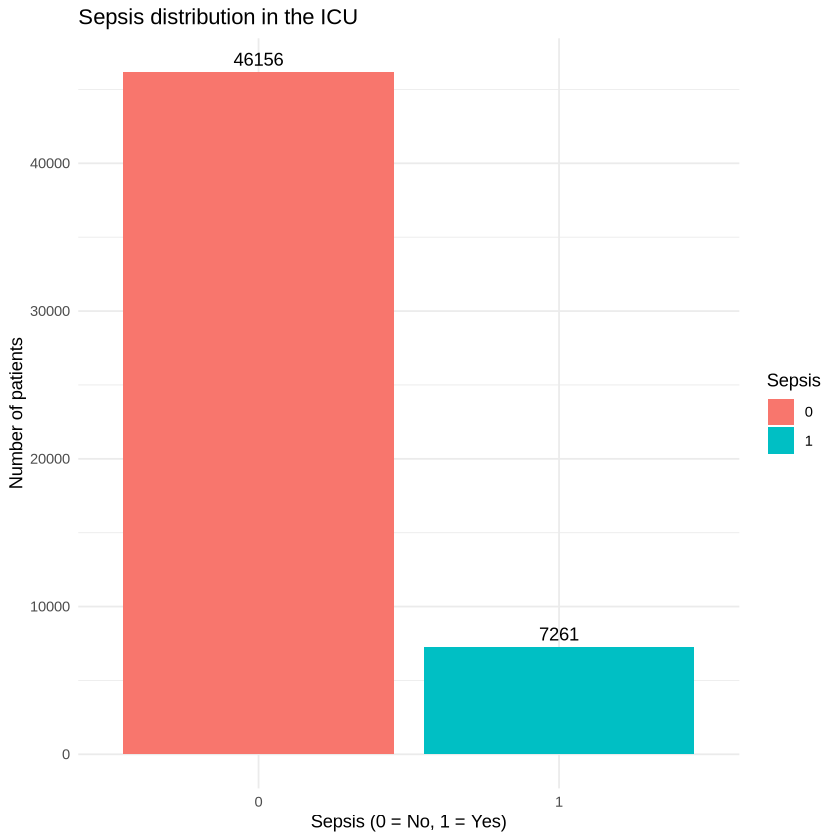

In [151]:
library(ggplot2)

ggplot(cohort_unique, aes(x = sepsis, fill = sepsis)) +
  geom_bar() +
  geom_text(stat='count', aes(label=after_stat(count)), vjust=-0.5) +
  labs(title = "Sepsis distribution in the ICU",
       x = "Sepsis (0 = No, 1 = Yes)",
       y = "Number of patients",
       fill = "Sepsis") +
  theme_minimal()

#### Sepsis prevalence by gender

In [120]:
prevalence_gender <- cohort_unique %>%
  group_by(gender) %>%
  summarise(
    total_admissions = n(),
    sepsis_cases = sum(sepsis == "1"),
    non_sepsis_cases = sum(sepsis == "0"),
    prevalence_percent = (sepsis_cases / total_admissions) * 100
  )

prevalence_gender

gender,total_admissions,sepsis_cases,non_sepsis_cases,prevalence_percent
<chr>,<int>,<int>,<int>,<dbl>
F,23323,3179,20144,13.63032
M,30094,4082,26012,13.56417


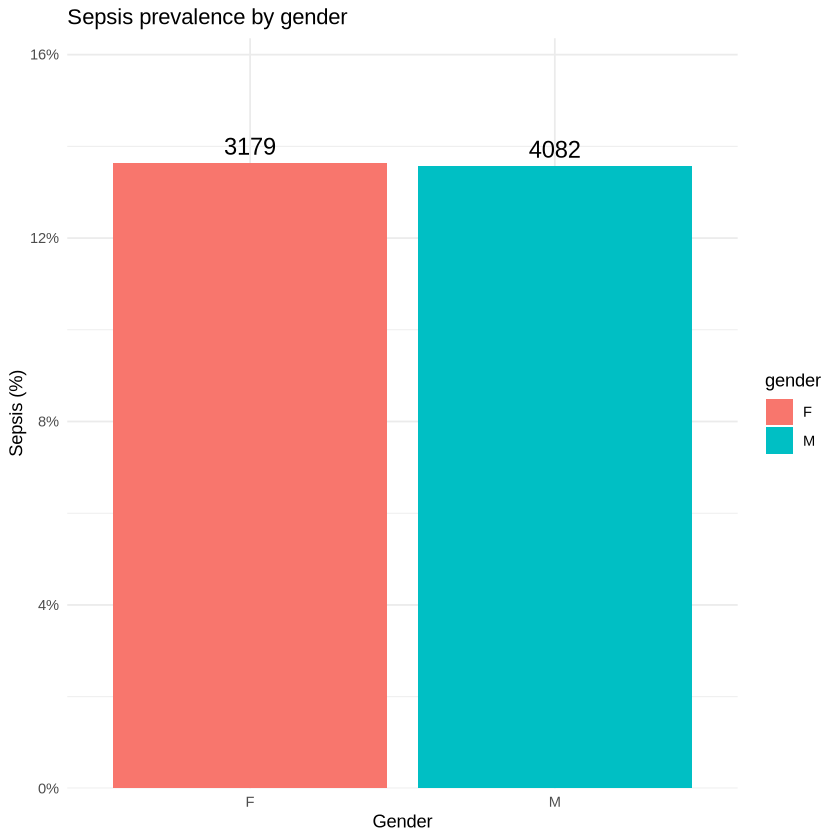

In [115]:
ggplot(prevalence_gender, aes(x = gender, y = prevalence_percent, fill = gender)) +
  geom_col() +
  geom_text(aes(label = sepsis_cases), 
            vjust = -0.5,
            size = 5) +
  scale_y_continuous(labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(0, 0.2))) +
  labs(title = "Sepsis prevalence by gender",
       y = "Sepsis (%)",
       x = "Gender") +
  theme_minimal()

#### Sepsis prevalence by age

In [130]:
prevalence_age <- cohort_unique %>%
  mutate(age_group = cut(age, 
                         breaks = c(16, 40, 60, 80, Inf), 
                         labels = c("16-40", "40-60", "60-80", "80+"),
                         right = FALSE)) %>%
  group_by(age_group) %>%
  summarise(
    total_admissions = n(),
    sepsis_cases = sum(sepsis == "1"),
    prevalence_prop = sepsis_cases / total_admissions
  ) %>%
  # Delate NA if there are unknown ages
  filter(!is.na(age_group))

prevalence_age

age_group,total_admissions,sepsis_cases,prevalence_prop
<fct>,<int>,<int>,<dbl>
16-40,5118,428,0.08362642
40-60,14678,1862,0.12685652
60-80,22252,3155,0.14178501
80+,11369,1816,0.15973261


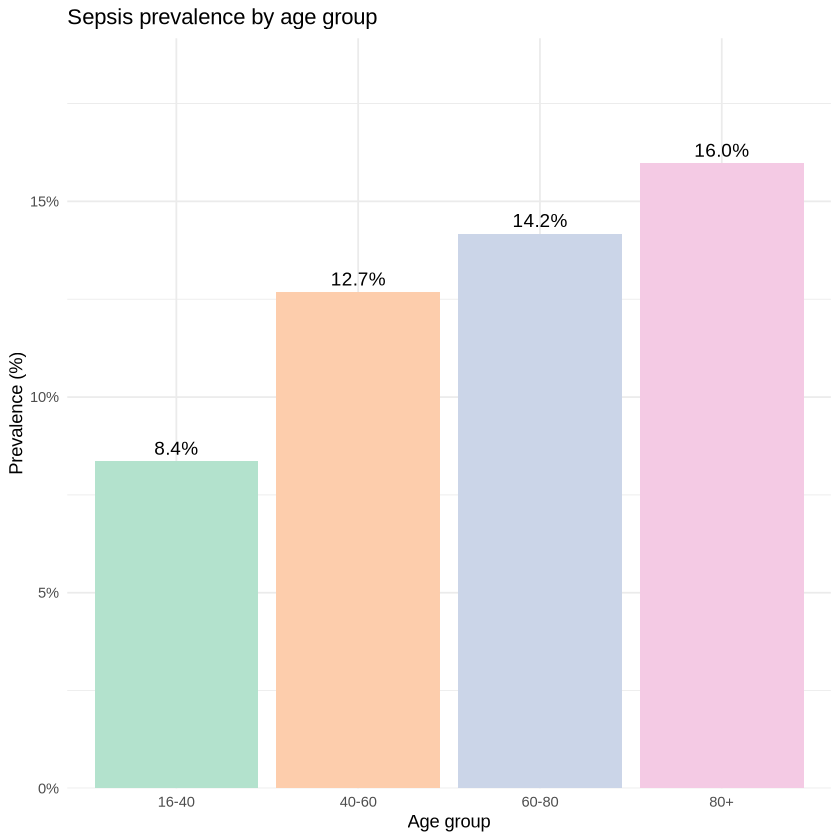

In [146]:
ggplot(prevalence_age, aes(x = age_group, y = prevalence_prop, fill = age_group)) +
  geom_col() +
  geom_text(aes(label = scales::percent(prevalence_prop, accuracy = 0.1)), 
            vjust = -0.5, size = 4) +
  scale_y_continuous(labels = scales::percent, 
                     expand = expansion(mult = c(0, 0.2))) +
  scale_fill_brewer(palette = "Pastel2") +
  labs(title = "Sepsis prevalence by age group",
       x = "Age group",
       y = "Prevalence (%)") +
  theme_minimal() +
  theme(legend.position = "none")

### Mortality

hospital_expire_flag,count,Percentage_Status
<fct>,<int>,<dbl>
0,4896,67.42873
1,2365,32.57127


Sepsis mortality rate is 32.57 %

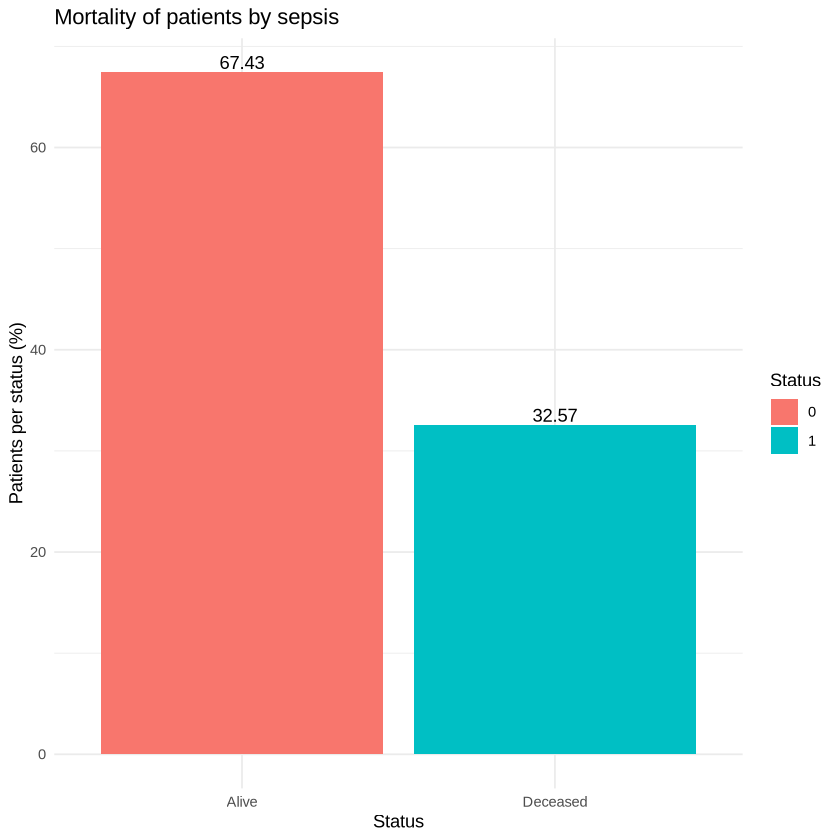

In [49]:
#With sepsis
df2 <- cohort_unique%>%
    filter(sepsis == 1) %>%
    select(hospital_expire_flag) %>%
    group_by(hospital_expire_flag)%>%
    summarise(count = n())%>%
    mutate(Percentage_Status = count / sum(count) * 100)
head(df2)

mortality_sepsis <- df2 %>%
  filter(hospital_expire_flag == 1) %>%
  pull(Percentage_Status)
cat("Sepsis mortality rate is", round(mortality_sepsis,2), "%")

ggplot(df2,
       aes(x= factor(hospital_expire_flag, levels = c(0,1), labels = c('Alive','Deceased')),
           y=Percentage_Status, 
           fill = hospital_expire_flag, 
           label=round(Percentage_Status,2))
       ) +
  geom_col() +
  geom_text(position=position_dodge(0.5), vjust=-0.25) +
  labs(x = 'Status',
      y = 'Patients per status (%)',
      title = 'Mortality of patients by sepsis',
      fill = 'Status') + 
  theme_minimal()

hospital_expire_flag,count,Percentage_Status
<fct>,<int>,<dbl>
0,41981,90.954589
1,4175,9.045411


Mortality rate without sepsis is 9.05 %

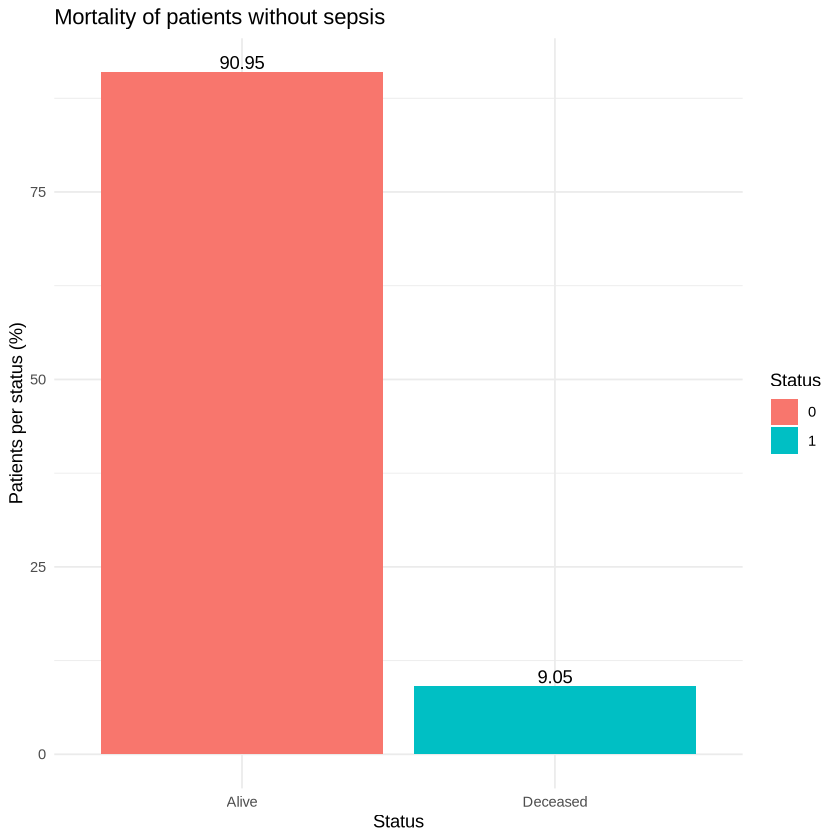

In [157]:
#Without sepsis
df2 <- cohort_unique%>%
    filter(sepsis == 0) %>%
    select(hospital_expire_flag) %>%
    group_by(hospital_expire_flag)%>%
    summarise(count = n())%>%
    mutate(Percentage_Status = count / sum(count) * 100)
head(df2)

mortality_sepsis <- df2 %>%
  filter(hospital_expire_flag == 1) %>%
  pull(Percentage_Status)
cat("Mortality rate without sepsis is", round(mortality_sepsis,2), "%")

ggplot(df2,
       aes(x= factor(hospital_expire_flag, levels = c(0,1), labels = c('Alive','Deceased')),
           y=Percentage_Status, 
           fill = hospital_expire_flag, 
           label=round(Percentage_Status,2))
       ) +
  geom_col() +
  geom_text(position=position_dodge(0.5), vjust=-0.25) +
  labs(x = 'Status',
      y = 'Patients per status (%)',
      title = 'Mortality of patients without sepsis',
      fill = 'Status') + 
  theme_minimal()

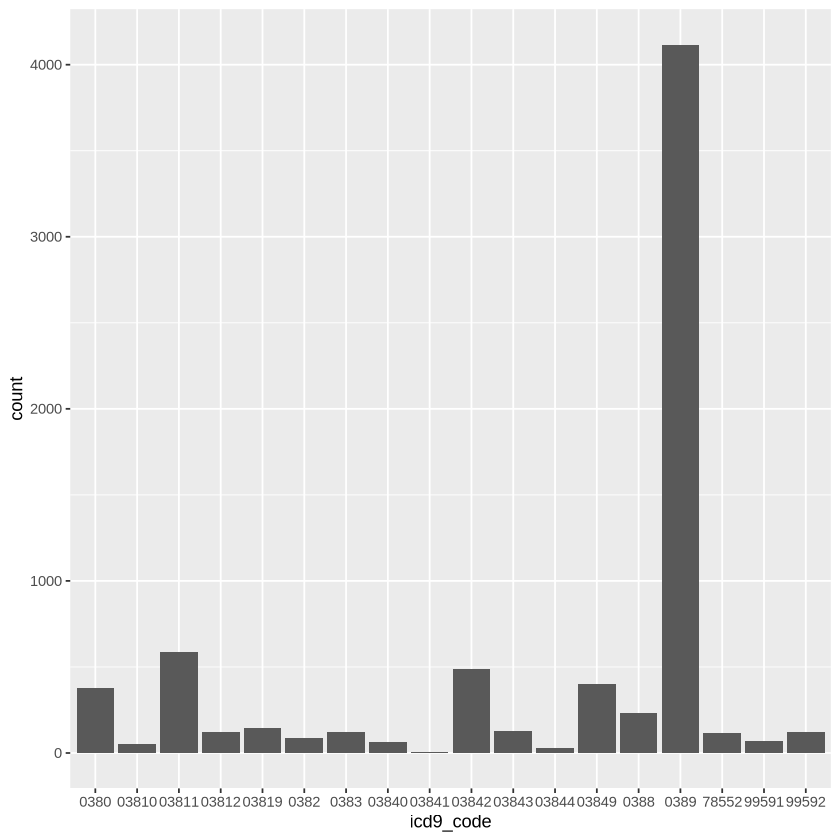

In [51]:
#Petit apunt no se si es un problema pero al icd9_code com que prioritzo sempre el mes baix, molts dels records son agafant el matex icd9_code
ggplot(patients_sepsis, aes(x=icd9_code)) + geom_bar()

### Logistic regresion

We will build a logistic regression to see if we can have a model to predict if the patient in the icu with sepsis will die or not using the following predictor variables (age, gender, ethnicity, insurance,	icd9_code), using hospital_expire_flag as the response variable. 

In [52]:
#install.packages("caTools")

In [53]:
library(caTools)

In [71]:
#Splitting the data for training (90%) and testing(10%)
set.seed(100)
spl = sample.split(patients_sepsis$hospital_expire_flag, SplitRatio = 0.9)
train = subset(patients_sepsis, spl == TRUE)
test = subset(patients_sepsis, spl == FALSE)

In [72]:
logistic <- glm(hospital_expire_flag ~ age + gender + ethnicity + insurance + icd9_code, data = train, family = 'binomial')
summary(logistic)


Call:
glm(formula = hospital_expire_flag ~ age + gender + ethnicity + 
    insurance + icd9_code, family = "binomial", data = train)

Coefficients:
                                                                    Estimate
(Intercept)                                                       -7.720e-01
age                                                                1.233e-03
genderM                                                            2.256e-02
ethnicityAMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE  1.405e+01
ethnicityASIAN                                                    -1.078e+00
ethnicityASIAN - ASIAN INDIAN                                     -1.773e+00
ethnicityASIAN - CAMBODIAN                                        -1.683e+00
ethnicityASIAN - CHINESE                                          -3.669e-01
ethnicityASIAN - FILIPINO                                          1.430e+01
ethnicityASIAN - KOREAN                                           -2.088e-01
ethn

**Pregunta** No se si valdria la pena mirar d'agrupar les ethnicities en ASIAN, BLACK, HISPANIC/LATINO, WHIHE, i OTHERS (ja que n'hi ha moltes i al model no li va gaire be). Sinó ho podem posar com a cosa a millorar.

In [73]:
predict_test <- predict(logistic, type = "response", newdata = test)
head(predict_test)

1         2         3         4         5         6 
0.3687688 0.4856561 0.2876763 0.3368956 0.3615382 0.2922448

In [74]:
#ROC Curve 
library(pROC)

In [75]:
roc_curve <- roc(response = test$hospital_expire_flag, predictor = predict_test)
auc_value <- auc(roc_curve)
cat('AUC:',round(auc_value,3))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC: 0.622

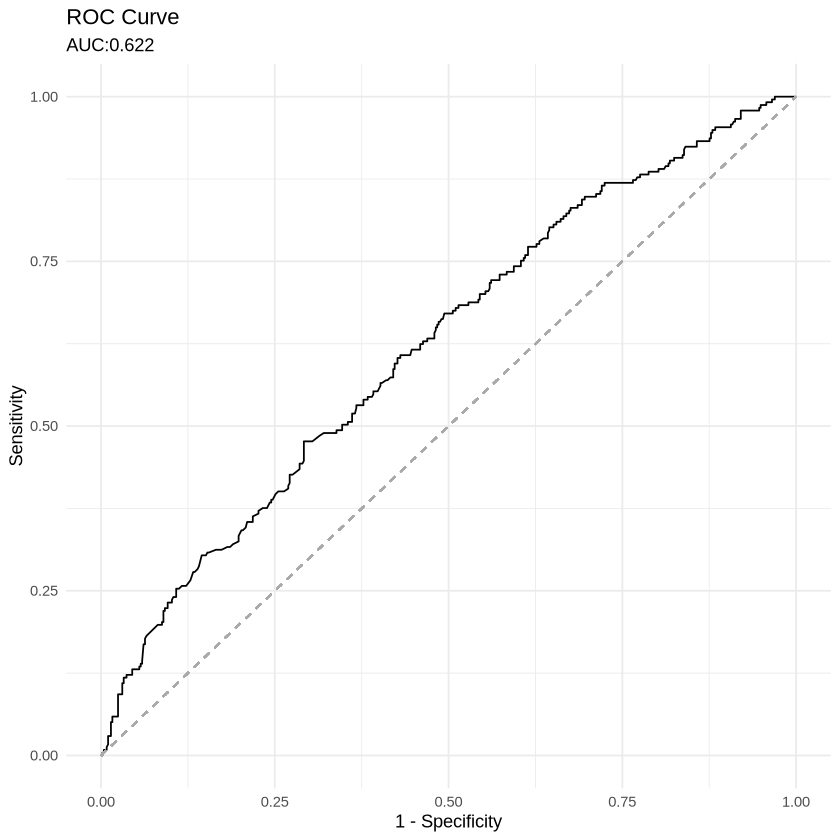

In [76]:
ggroc(data=roc_curve, legacy.axes = TRUE) +
    geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), 
               color = "darkgrey", linetype = "dashed") + #The diagonal line
  theme_minimal() + 
  labs(title = "ROC Curve", 
       subtitle = paste0("AUC:", round(auc_value, 3)),
       x = "1 - Specificity", 
       y = "Sensitivity") 

In [77]:
#Optimal threshold
coords <- coords(roc_curve, "best", best.method = "closest.topleft")
best_threshold <- coords$threshold

cat("Optimal threshold based on ROC curve:", best_threshold, "\n")


Optimal threshold based on ROC curve: 0.3340145 


In [78]:
#Conusion matrix
predicted_class <- ifelse(predict_test >= best_threshold, 1, 0)
confusion_matrix <- table(test$hospital_expire_flag, predicted_class)
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
confusion_matrix
cat("Accuracy:", accuracy, "\n") #The model is correct % of the time


   predicted_class
      0   1
  0 281 209
  1  94 143

Accuracy: 0.5832187 


In [79]:
TN <- confusion_matrix[1,1] 
FP <- confusion_matrix[1,2] 
FN <- confusion_matrix[2,1] 
TP <- confusion_matrix[2,2] 

Sensitivity <- TP / (TP + FN)
Specificity <- TN / (TN + FP)
PPV <- TP / (TP + FP)
NPV <- TN / (TN + FN)

cat("Sensitivity: ", Sensitivity, "\n")
cat("Specificity: ", Specificity, "\n")
cat("PPV or Precision:",PPV, "\n")
cat("NPV:",NPV, "\n")

Sensitivity:  0.6033755 
Specificity:  0.5734694 
PPV or Precision: 0.40625 
NPV: 0.7493333 
